In [5]:
import matplotlib.pyplot as plt
import numba
import numpy as np
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
from gudhi.clustering.tomato import Tomato
import umap
import torch
import plotly.graph_objects as go
from persim import plot_diagrams
from collections import Counter
from circular_cords import get_coords
from fix_umap_bug import fix_umap_bug
import pandas as pd

fix_umap_bug()

Import the data. "activity" is then a 40000xneurons matrix with all activations.

In [34]:
layer = "inception4e"
activity = np.load(f"activations/ILSVRC2015/{layer}.npy")
print(activity.shape)
neurons = activity.shape[1]

(50761, 832)


In [35]:
cluster_info = pd.read_pickle(f"data/clusters/{layer}.pkl")
print(cluster_info.head(10))

Empty DataFrame
Columns: [cluster_id, cluster_size, cluster_members, longest_bar, Top 10 longest bars]
Index: []


Use UMap to project to 2D

In [36]:
layout = umap.UMAP(
    n_components=neurons, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(activity)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=832, n_neighbors=20, verbose=True)
Thu Jun  2 14:25:35 2022 Construct fuzzy simplicial set
Thu Jun  2 14:25:35 2022 Finding Nearest Neighbors
Thu Jun  2 14:25:35 2022 Building RP forest with 16 trees
Thu Jun  2 14:25:36 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Thu Jun  2 14:25:42 2022 Finished Nearest Neighbor Search
Thu Jun  2 14:25:43 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Jun  2 14:39:30 2022 Finished embedding


Cluster the UMap output with kMeans to get 10 cluster. Then visualize.

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/point_cloud/dtm.py:164: RuntimeWarning:

overflow encountered in power

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/clustering/tomato.py:174: RuntimeWarning:

divide by zero encountered in log

/opt/homebrew/Caskroom/miniforge/base/envs/act/lib/python3.9/site-packages/gudhi/clustering/tomato.py:286: RuntimeWarning:

invalid value encountered in double_scalars



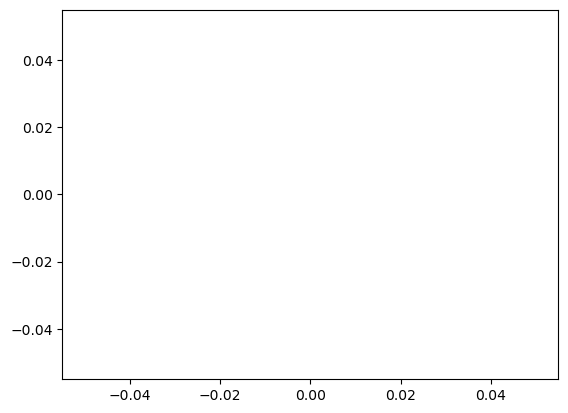

In [68]:
t = Tomato(density_type="logDTM", k=100)  # logDTM, DTM, ‘KDE’ or ‘logKDE’
clusters = t.fit_predict(activity)
t.plot_diagram()

In [69]:
print(t.n_clusters_)
print(Counter(t.labels_).most_common(10))
clusters = t.labels_

401
[(146, 13221), (28, 7229), (69, 2753), (41, 2659), (18, 2502), (32, 1956), (73, 990), (311, 697), (98, 683), (134, 665)]


In [41]:
t_new = t
t_new.n_clusters_ = 40
print(t_new.n_clusters_)
print(t.n_clusters_)
print(Counter(t_new.labels_).most_common(10))
clusters = t_new.labels_

40
40
[(1, 50584), (22, 17), (0, 15), (8, 15), (20, 13), (7, 12), (15, 12), (17, 8), (16, 7), (24, 7)]


In cluster 7 there is a circle in the activations. To see it we apply UMAp as a prepocessing step. Then it's visible with persistent homology. 

In [40]:
cluster = []
for n in range(len(clusters)):
    if clusters[n] in [79]:
        cluster.append(activity[n])
cluster = np.array(cluster)
print(cluster.shape)

(1303, 832)


In [42]:
layout2 = umap.UMAP(
    n_components=neurons, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)
M = squareform(pdist(layout2, "euclidean"))

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=832, n_neighbors=20, verbose=True)
Thu Jun  2 15:17:21 2022 Construct fuzzy simplicial set
Thu Jun  2 15:17:22 2022 Finding Nearest Neighbors
Thu Jun  2 15:17:23 2022 Finished Nearest Neighbor Search
Thu Jun  2 15:17:23 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Jun  2 15:17:34 2022 Finished embedding


In [43]:
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)

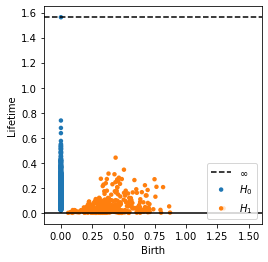

In [44]:
plot_diagrams(persistence["dgms"], lifetime=True, show=True)

Use the code to compute a circular parameter for the identified circle using circular parametrization (de Silva):

In [46]:
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)


f, theta_matrix, verts, num_verts = get_coords(
    cocycle=cocycles[iMax[-1]],
    threshold=threshold,
    num_sampled=len(layout2),
    dists=M,
    coeff=coeff,
    bool_smooth_circle="perea",  # "graph", "old", "perea"
)

number of vertices = 1303
number of edges = 43495


Visualize it after projecting to 3d: 

In [47]:
layout_3d = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster)

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d[:, 0],
            y=layout_3d[:, 1],
            z=layout_3d[:, 2],
            mode="markers",
            marker=dict(
                size=12, color=f, colorscale="hsv", opacity=0.8, showscale=True
            ),
        )
    ]
)
# Cyclic colors: 'twilight', 'twilight_shifted', 'hsv', Default: Viridis
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("circular_feature_3D.html")
fig.show()

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Thu Jun  2 15:19:13 2022 Construct fuzzy simplicial set
Thu Jun  2 15:19:14 2022 Finding Nearest Neighbors
Thu Jun  2 15:19:14 2022 Finished Nearest Neighbor Search
Thu Jun  2 15:19:14 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Jun  2 15:19:16 2022 Finished embedding


Not all neurons contribute equally to this circle. We identify the ones that tune to it: 

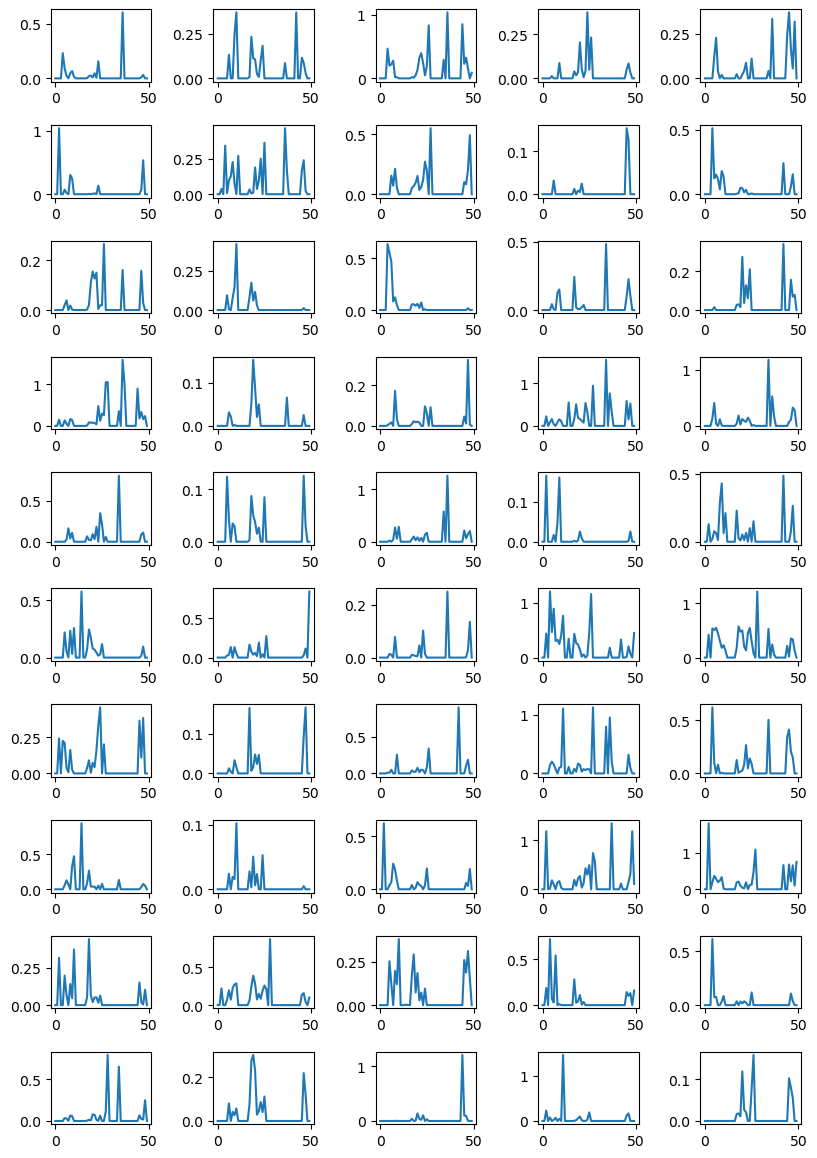

In [48]:
circ_rates = np.zeros([neurons, 50])
counts, bins = np.histogram(f, bins=50, density=True)
for b in range(len(bins) - 1):
    for n in range(neurons):
        rates = []
        for x in range(len(cluster)):
            if bins[b] < f[x] <= bins[b + 1]:
                rates.append(cluster[x, n])
        if rates:
            circ_rates[n, b] = np.mean(rates)
        else:
            circ_rates[n, b] = 0

fig, axs = plt.subplots(10, 5, figsize=(8.27, 11.69))
for n in range(5):
    for m in range(10):
        axs[m, n].plot(range(50), circ_rates[m * 5 + n])
fig.tight_layout()

To quantify this we compute the information rate of the neurons:

/var/folders/dv/2b73qfmn5rv5r60s5j4vz8dr0000gn/T/ipykernel_46572/4237734687.py:2: RuntimeWarning:

invalid value encountered in true_divide



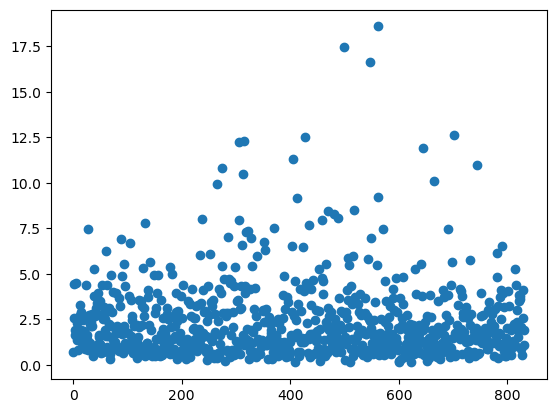

In [49]:
def inform_rate(mean_n, data, coun):
    return np.sum(data * np.log2((data / mean_n) + 0.0000001) * coun)


mean = np.mean(cluster, axis=0)

inform_rates = [inform_rate(mean[n], circ_rates[n, :], counts) for n in range(neurons)]

plt.scatter(range(neurons), inform_rates)
plt.show()

Then we pick the ones with an information rate higher then 0.2:

In [55]:
inform = 5
high_inform = np.where(np.array(inform_rates) > inform)[0]
print(high_inform)
len(high_inform)

[ 28  39  60  88  94 104 128 133 141 178 233 238 252 265 274 275 286 298
 305 306 311 313 314 319 322 328 330 339 352 354 370 403 405 412 424 427
 435 453 459 465 469 481 488 499 506 508 515 518 544 547 548 559 561 562
 571 629 641 644 665 690 698 702 731 744 780 791 815]


67

Lets compute everything again but just with these neurons:

In [56]:
cluster_new = cluster[:, np.where(np.array(inform_rates) > inform)[0]]
data_new = activity[:, np.where(np.array(inform_rates) > inform)[0]]

layout_3d_cluster = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Thu Jun  2 15:21:18 2022 Construct fuzzy simplicial set
Thu Jun  2 15:21:18 2022 Finding Nearest Neighbors
Thu Jun  2 15:21:18 2022 Finished Nearest Neighbor Search
Thu Jun  2 15:21:18 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Jun  2 15:21:19 2022 Finished embedding


In [57]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_cluster[:, 0],
            y=layout_3d_cluster[:, 1],
            z=layout_3d_cluster[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("circular_feature_3D_after_clustering_2.html")
fig.show()

In [52]:
cluster_new_crop = cluster_new[
    np.where(
        (np.array(layout_3d_cluster)[:, 0] > 9)
        & (np.array(layout_3d_cluster)[:, 1] < 7)
        & (np.array(layout_3d_cluster)[:, 2] > 4.8)
    )[0],
    :,
]
# cluster_new_crop = cluster_new
layout_3d_new = umap.UMAP(
    n_components=3, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine"
).fit_transform(cluster_new_crop)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=3, n_neighbors=20, verbose=True)
Tue Mar  8 23:50:15 2022 Construct fuzzy simplicial set
Tue Mar  8 23:50:15 2022 Finding Nearest Neighbors
Tue Mar  8 23:50:15 2022 Finished Nearest Neighbor Search
Tue Mar  8 23:50:15 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Mar  8 23:50:17 2022 Finished embedding


In [58]:
cluster_new_crop = cluster_new

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_components=67, n_neighbors=20, verbose=True)
Thu Jun  2 15:21:36 2022 Construct fuzzy simplicial set
Thu Jun  2 15:21:37 2022 Finding Nearest Neighbors
Thu Jun  2 15:21:37 2022 Finished Nearest Neighbor Search
Thu Jun  2 15:21:37 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Jun  2 15:21:39 2022 Finished embedding


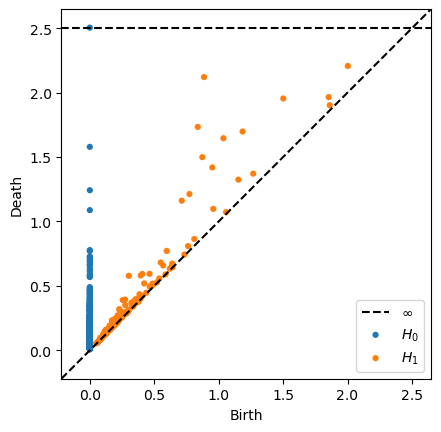

In [59]:
layout3 = umap.UMAP(
    n_components=len(high_inform),
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
).fit_transform(cluster_new_crop)
M = squareform(pdist(layout3, "euclidean"))
maxdim = 1
coeff = 47
thresh = np.max(M[~np.isinf(M)])
persistence = ripser(
    M, maxdim=maxdim, coeff=coeff, do_cocycles=True, distance_matrix=True, thresh=thresh
)
diagrams = persistence[
    "dgms"
]  # the multiset describing the lives of the persistence classes

plot_diagrams(diagrams, show=True)
cocycles = persistence["cocycles"][
    1
]  # the cocycle representatives for the 1-dim classes
births1 = diagrams[1][:, 0]  # the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1]  # the time of death for the 1-dim classes
lives1 = deaths1 - births1  # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)

threshold = births1[iMax[-1]] + (deaths1[iMax[-1]] - births1[iMax[-1]]) * (9 / 10)

cocycle = cocycles[iMax[-1]]

In [60]:
f_new, theta_matrix, verts_new, num_verts = get_coords(
    cocycle,
    threshold,
    len(layout3),
    M,
    47,
    "perea",  # "graph", "old", "perea"
)

number of vertices = 1303
number of edges = 114719


In [64]:
layout_3d_new = layout_3d_cluster

In [65]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=layout_3d_new[:, 0],
            y=layout_3d_new[:, 1],
            z=layout_3d_new[:, 2],
            mode="markers",
            marker=dict(
                size=12,
                color=f_new,
                colorscale="hsv",
                opacity=0.8,
                showscale=True,
            ),
        )
    ]
)
fig.update_layout(
    autosize=False, width=1000, height=700, margin=dict(l=0, r=0, b=0, t=0)
)
# fig.write_html("circular_feature_3D_final.html")
fig.show()

In [58]:
np.save(f"data/circle_4b", cluster)

We visulize the circle using using the lucent library. For that end we calculate average activation vectors for 50 overlapping patches along the circular parameter, Then we visulize those 50 average activation vectors. 

In [66]:
buckets = 10
linsp = np.linspace(f_new.min(), f_new.max(), buckets + 1)

clusters_overlap = []
for a in range(1, buckets):
    c = []
    for p in range(len(f_new)):
        if linsp[a - 1] < f_new[p] < linsp[a + 1]:
            c.append(cluster_new_crop[p])
    clusters_overlap.append(c)

c = []
for p in range(len(f_new)):
    if linsp[buckets - 1] < f_new[p] or f_new[p] < linsp[1]:
        c.append(cluster_new_crop[p])
clusters_overlap.append(c)
av_clusters_overlap = [np.mean(overlap, axis=0) for overlap in clusters_overlap]

print(list(map(lambda a: a.shape, av_clusters_overlap)))
print(list(map(len, clusters_overlap)))

[(67,), (67,), (67,), (67,), (67,), (67,), (67,), (67,), (67,), (67,)]
[743, 492, 286, 111, 23, 1, 61, 72, 188, 627]


Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:15<00:00,  6.77it/s]



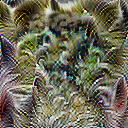

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:14<00:00,  6.91it/s]



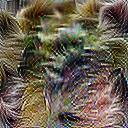

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.68it/s]



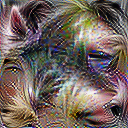

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:22<00:00,  6.18it/s]



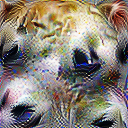

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:20<00:00,  6.34it/s]



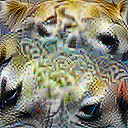

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.44it/s]



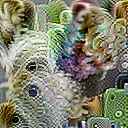

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:18<00:00,  6.55it/s]



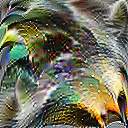

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:20<00:00,  6.34it/s]



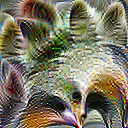

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:19<00:00,  6.45it/s]



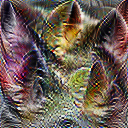

100%|█████████████████████████████████████████████████████████████████████| 512/512 [01:16<00:00,  6.68it/s]



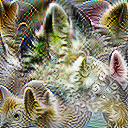

In [67]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel(layer, n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0
100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



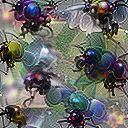

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.91it/s]



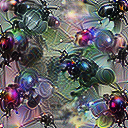

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.93it/s]



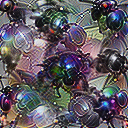

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.78it/s]



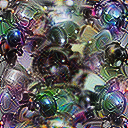

100%|█████████████████████████████████████████| 512/512 [01:04<00:00,  7.88it/s]



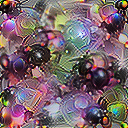

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.82it/s]



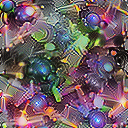

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.76it/s]



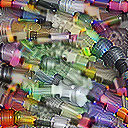

100%|█████████████████████████████████████████| 512/512 [01:07<00:00,  7.54it/s]



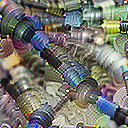

100%|█████████████████████████████████████████| 512/512 [01:05<00:00,  7.83it/s]



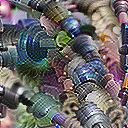

100%|█████████████████████████████████████████| 512/512 [01:06<00:00,  7.73it/s]



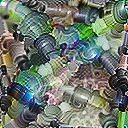

In [39]:
from lucent.optvis import render, param, transform, objectives

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True).eval()

pics = []
channel = lambda n: objectives.channel("inception4e", n)
for n in range(len(av_clusters_overlap)):
    a = []
    for m in range(len(high_inform)):
        a.append(av_clusters_overlap[n][m] * channel(high_inform[m]))
    obj = sum(a)
    d = render.render_vis(model, obj, show_inline=True)
    pics.append(d)

In [45]:
for i, im in enumerate(pics):
    np.save(f"data/circle_pics/circle_3/im_{i}.npy", im[0][0])

In [46]:
from PIL import Image

a = np.load("data/circle_pics/circle_3/im_1.npy")

a = (a * 255).astype(np.uint8)

ima = Image.fromarray(obj=a, mode="RGB")
ima.show()